In [5]:
from utils.long_residuals_mlp import *
from utils.utils import *
! pip install --upgrade pip
import cv2
from utils.utils import *
from utils.MLP import *
from utils.long_residuals_mlp import *
from utils.short_residuals_mlp import *

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Defaulting to user installation because normal site-packages is not writeable


In [6]:
PATCH_SIZE = 32
CLASSES      = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

MODEL_WEIGHTS = '/home/merles/Baixades/mast/C3/W2 C3/Task2/my_first_mlp.h5'

images_directory = '/home/merles/Baixades/mast/C3/W2 C3/MIT_split'

The following cell is NOT to be run!!!!!!

In [7]:
EMBEDDINGS_DIR = '/home/merles/Baixades/mast/C3/W2 C3/Task2/embeddings'
PATCH_SIZE = 32

N_CLUSTERS=128
N_NEIGHBORS = 5
METRIC = 'euclidean'
WEIGHT = 'distance'

In [8]:
embeddings_dict = read_embeddings(directory=os.path.join(EMBEDDINGS_DIR, str(PATCH_SIZE)))

training_files, training_labels = load_data_from_directory('/home/merles/Baixades/mast/C3/W2 C3/MIT_split/train')
test_files, test_labels = load_data_from_directory('/home/merles/Baixades/mast/C3/W2 C3/MIT_split/test')

training_embeddings = np.array([embeddings_dict[os.path.basename(file)] for file in training_files])
test_embeddings = np.array([embeddings_dict[os.path.basename(file)] for file in test_files])

training_embeddings = training_embeddings.reshape((1881 * 64, 256))
test_embeddings = test_embeddings.reshape((807 * 64, 256))

print(training_embeddings.shape)
print(test_embeddings.shape)

(120384, 256)
(51648, 256)


In [9]:
def create_visual_words(image_paths, descriptors_dictionary, codebook):
    visual_words = {}
    for image_path in image_paths:
        descriptor = descriptors_dictionary[os.path.basename(image_path)]
        labels = codebook.predict(descriptor)
        visual_words[image_path] = np.bincount(labels, minlength=codebook.n_clusters)
    return np.array(list(visual_words.values()))

codebook = MiniBatchKMeans(n_clusters=N_CLUSTERS,
                           verbose=False, 
                           batch_size=2150,
                           compute_labels=False,
                           reassignment_ratio=0.01,
                           random_state=42)

codebook.fit(training_embeddings)
# create visual words for training data
train_visual_words = create_visual_words(training_files, embeddings_dict, codebook)
# create visual words for test data
test_visual_words = create_visual_words(test_files, embeddings_dict, codebook)

/home/merles/.sage/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [43]:
N_CLUSTERS=128
N_NEIGHBORS = 5
METRIC = 'manhattan'
# Metrics can be: minkowski, manhattan (L1), chebyshev, euclidean (L2), cosine (or custom)
WEIGHT = 'uniform'
# wheight can be: uniform, distance (or custom) -> aquí agafo ja distance i prou

n_neighbors_values = list(range(1, 26))
accuracy_values_manhattan = []

for i in n_neighbors_values:
    N_NEIGHBORS = i#+1
    # fit kNN classifier
    knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS,n_jobs=-1,metric=METRIC, weights=WEIGHT)
    knn.fit(train_visual_words, training_labels)
    # predict labels for test data
    pred_labels = knn.predict(test_visual_words)
    # get accuracy metric for current run
    accuracy, recall, precision, f1 = get_metrics(test_labels, pred_labels)
    accuracy_values_manhattan.append(accuracy)

In [44]:
N_CLUSTERS=128
N_NEIGHBORS = 5
METRIC = 'euclidean'
# Metrics can be: minkowski, manhattan (L1), chebyshev, euclidean (L2), cosine (or custom)
WEIGHT = 'uniform'
# wheight can be: uniform, distance (or custom) -> aquí agafo ja distance i prou

n_neighbors_values = list(range(1, 26))
accuracy_values_euclidean = []

for i in n_neighbors_values:
    N_NEIGHBORS = i#+1
    # fit kNN classifier
    knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS,n_jobs=-1,metric=METRIC, weights=WEIGHT)
    knn.fit(train_visual_words, training_labels)
    # predict labels for test data
    pred_labels = knn.predict(test_visual_words)
    # get accuracy metric for current run
    accuracy, recall, precision, f1 = get_metrics(test_labels, pred_labels)
    accuracy_values_euclidean.append(accuracy)

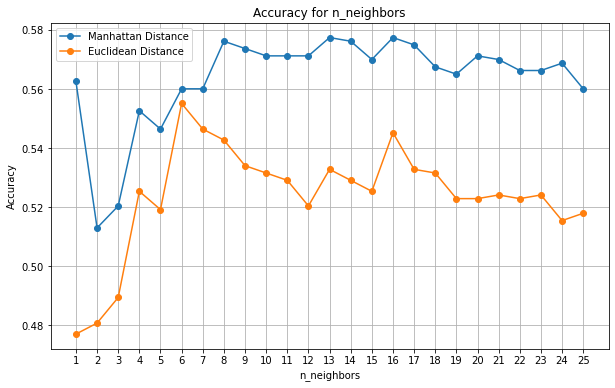

In [45]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_values, accuracy_values_manhattan, marker='o', linestyle='-', label='Manhattan Distance')
plt.plot(n_neighbors_values, accuracy_values_euclidean, marker='o', linestyle='-', label='Euclidean Distance')
plt.title('Accuracy for n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(n_neighbors_values)
plt.legend()  # Adding legend
plt.grid(True)
plt.show()